### Description

#### Context:
AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalised campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customers queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help

#### Objective:
To identify different segments in the existing customer based on their spending patterns as well as past interaction with the bank.

#### Dataset:  
ALLLife bank

#### Data Description: 

Data is of various customers of a bank with their credit limit, the total number of credit cards the customer has, and different channels through which customer has contacted the bank for any queries, different channels include visiting the bank, online and through a call centre.

Apply the concepts and techniques you have learned in the previous weeks and summarize your insights at the end.

### Problem Statement:

AllLife Bank needs to understand their customer base betterr through customer segmentation. The results of the segmentation will be used to create a marketing campaign for new customers, as well as a up-selling marketing campaign for existing customers.

AllLife Bank would also like to identify service delivery issues and improve these through upgrarding services where neccesary.


#### Key Questions:
<ul>
    <li>Which variables are most important for clustering?</li>
    <li>How each cluster is different from the others?</li>
    <li>What are the business recommendations?</li>
</ul>


In [1]:
#setting up the notebook
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage,cophenet
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering 

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

ModuleNotFoundError: No module named 'sklearn.cluster'

In [83]:
#importing the dataset

data = pd.read_excel('Credit Card Customer Data.xlsx')

df = data.copy()

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


In [85]:
df.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [86]:
df2 = df[['Customer Key']]
df2.value_counts()

Customer Key
96929           2
47437           2
97935           2
50706           2
37252           2
               ..
68067           1
68040           1
68003           1
67911           1
11265           1
Length: 655, dtype: int64

There appears to be mistakes in the customer key. We will drop this column and the SI_No column too. As such we won't be adjusting the error.

In [87]:
#Dropping Sl_No & Customer Key 
df.drop('Sl_No',axis=1,inplace=True)


In [88]:
#Dropping Customer Key 
df.drop('Customer Key',axis=1,inplace=True)

In [89]:
df.isna().sum()



Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

<ul>
    <li>There are no null values to be dealt with</li>
</ul>

In [90]:
df.duplicated().sum()

11

<ul>
    <li>There are 11 duplicated records, we will drop these from the dataset</li>
    <li>No data is lost or gained by keeping the duplicates, as such we will simply drop them. We are clustering</li>
</ul>

In [91]:
df = df[(~df.duplicated())].copy()



In [92]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,649.0,34878.274268,37813.736638,3000.0,11000.0,18000.0,49000.0,200000.0
Total_Credit_Cards,649.0,4.708783,2.173763,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,649.0,2.397535,1.625148,0.0,1.0,2.0,4.0,5.0
Total_visits_online,649.0,2.624037,2.952888,0.0,1.0,2.0,4.0,15.0
Total_calls_made,649.0,3.590139,2.877911,0.0,1.0,3.0,5.0,10.0


### Observations:

<ul>
    <li>We will need to scale the data appropriately, as the range of Credit Limit is significantly larger than the other columns</li>
    <li>The int values for columns not Credit Limit can only be in steps of 1. We acnnot have 0.4 "visits to the bank"</li>
    <li>The dataset only includes customers who have at least one credit card </li>
</ul>

### Explaratory Data Analysis:

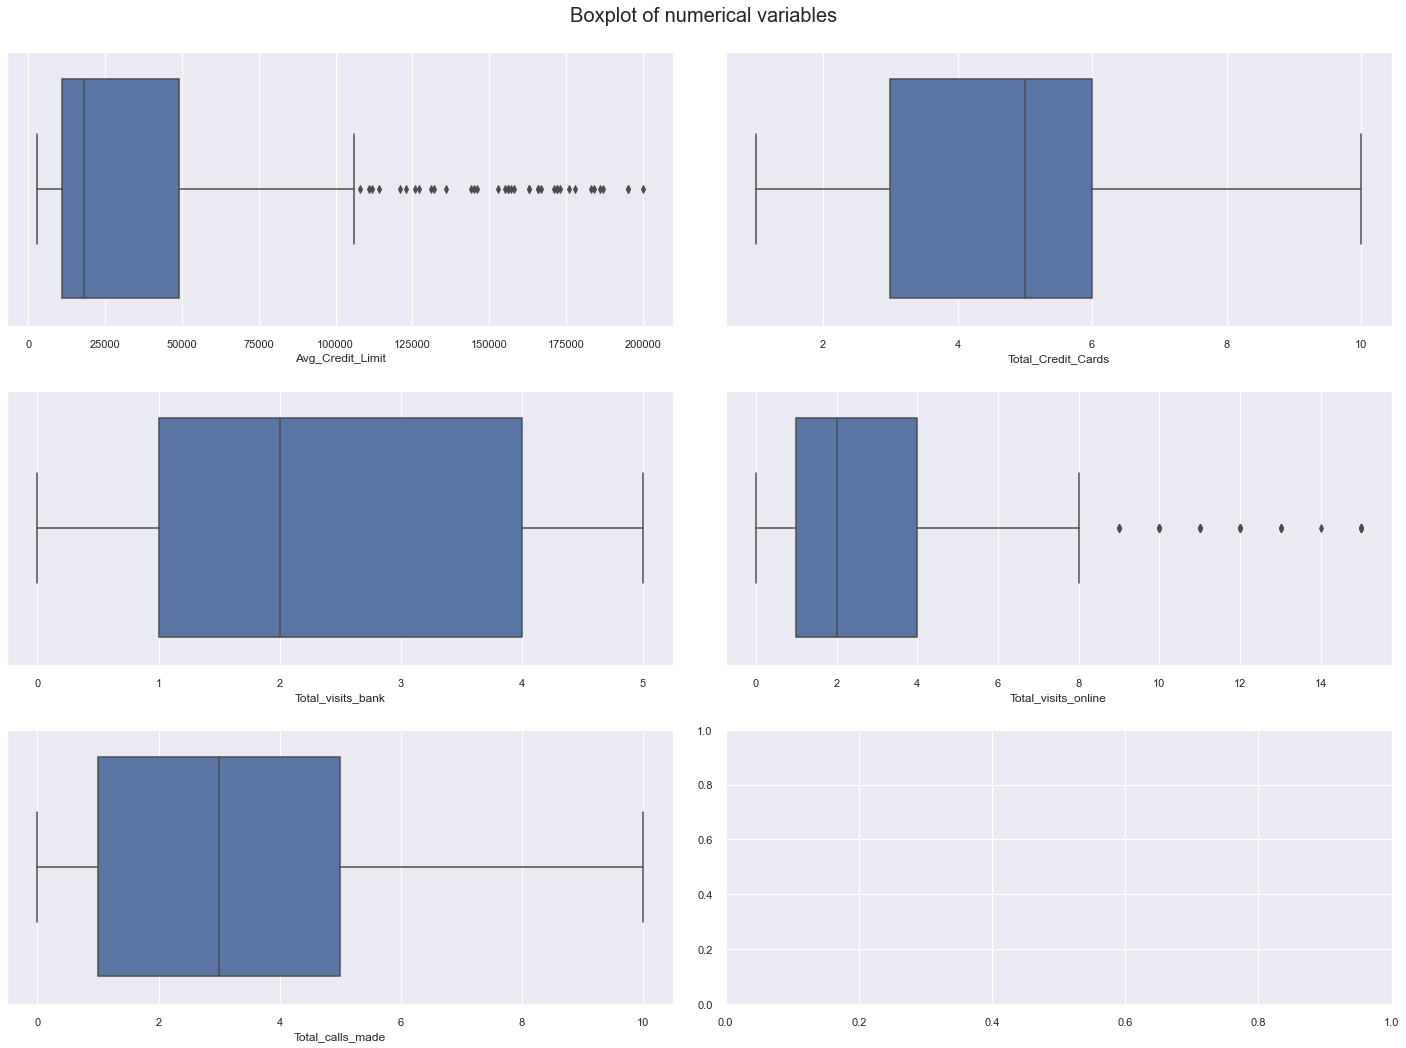

In [93]:
# selecting numerical columns
all_col = df.select_dtypes(include=np.number).columns.tolist()

fig, axes = plt.subplots(3, 2,  figsize=(20, 15))
fig.suptitle('Boxplot of numerical variables', fontsize=20)
counter = 0
for ii in range(3):
    sns.boxplot(ax=axes[ii][0],x=df[all_col[counter]])
    counter = counter+1
    if counter != 5:
        sns.boxplot(ax=axes[ii][1],x=df[all_col[counter]])
        counter = counter+1
    else:
        pass

fig.tight_layout(pad=2.0)



<ul>
    <li>Avg_Credit_Limit is heavily skewed with outliers</li>
    <li>Total_Visits_Online have a few outliers</li>
    <li>The remaining features appear to normally distributed.</li>  
</ul>

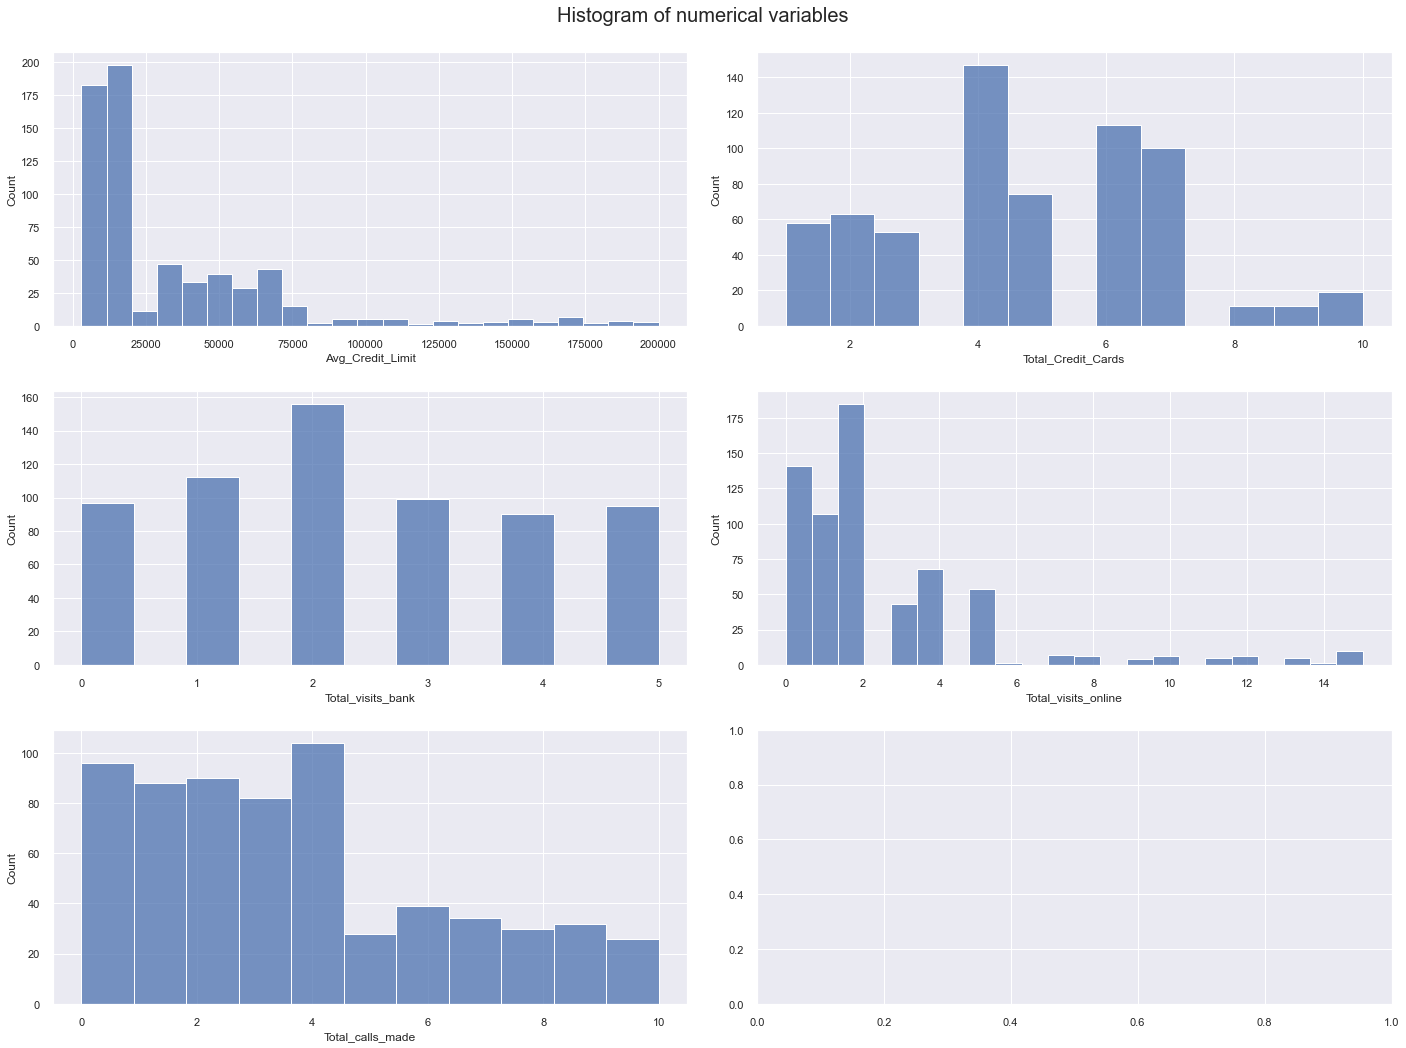

In [94]:
# select numerical columns
all_col = df.select_dtypes(include=np.number).columns.tolist()

fig, axes = plt.subplots(3, 2,  figsize=(20, 15))
fig.suptitle('Histogram of numerical variables', fontsize=20)
counter = 0
for ii in range(3):
    sns.histplot(ax=axes[ii][0],x=df[all_col[counter]])
    counter = counter+1
    if counter != 5:
        sns.histplot(ax=axes[ii][1],x=df[all_col[counter]])
        counter = counter+1
    else:
        pass

fig.tight_layout(pad=2.0)



<ul>
    <li>Most customers have 4 credit cards</li>
    <li>Customers visit the bank 2 or more times mor often than they do 1 or less</li>
    <li>The majority of customers visit 2 times online</li>
    <li>The Avg_Credit_Limit is heavily skewed left.</li>
</ul>

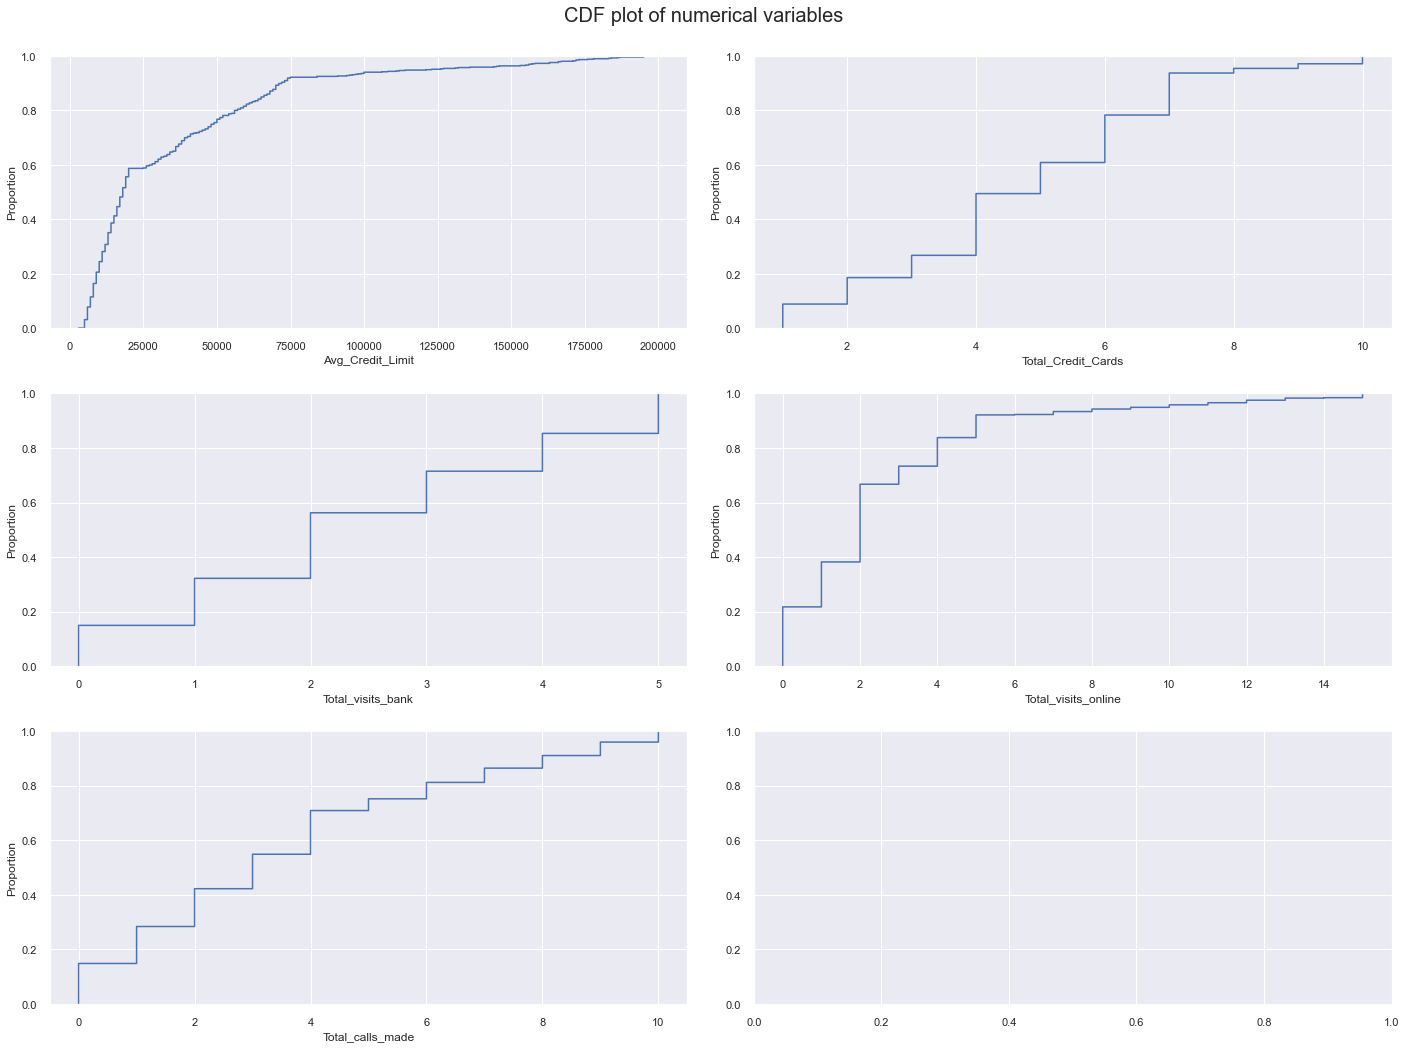

In [95]:
# select numerical columns
all_col = df.select_dtypes(include=np.number).columns.tolist()

fig, axes = plt.subplots(3, 2,  figsize=(20, 15))
fig.suptitle('CDF plot of numerical variables', fontsize=20)
counter = 0
for ii in range(3):
    sns.ecdfplot(ax=axes[ii][0],x=df[all_col[counter]])
    counter = counter+1
    if counter != 5:
        sns.ecdfplot(ax=axes[ii][1],x=df[all_col[counter]])
        counter = counter+1
    else:
        pass


fig.tight_layout(pad=2.0)

<ul>
    <li>90% of the customers have a Avg_Credit_Limit of 75000 or less</li>
    <li>80% of customers have up to 6 credit cards</li>
    <li>The majority of customers visit the bank 2 times in person</li>
    <li>While 80% of customers visit the bank online 4 or less times</li>
</ul>

### Bivariate Analysis

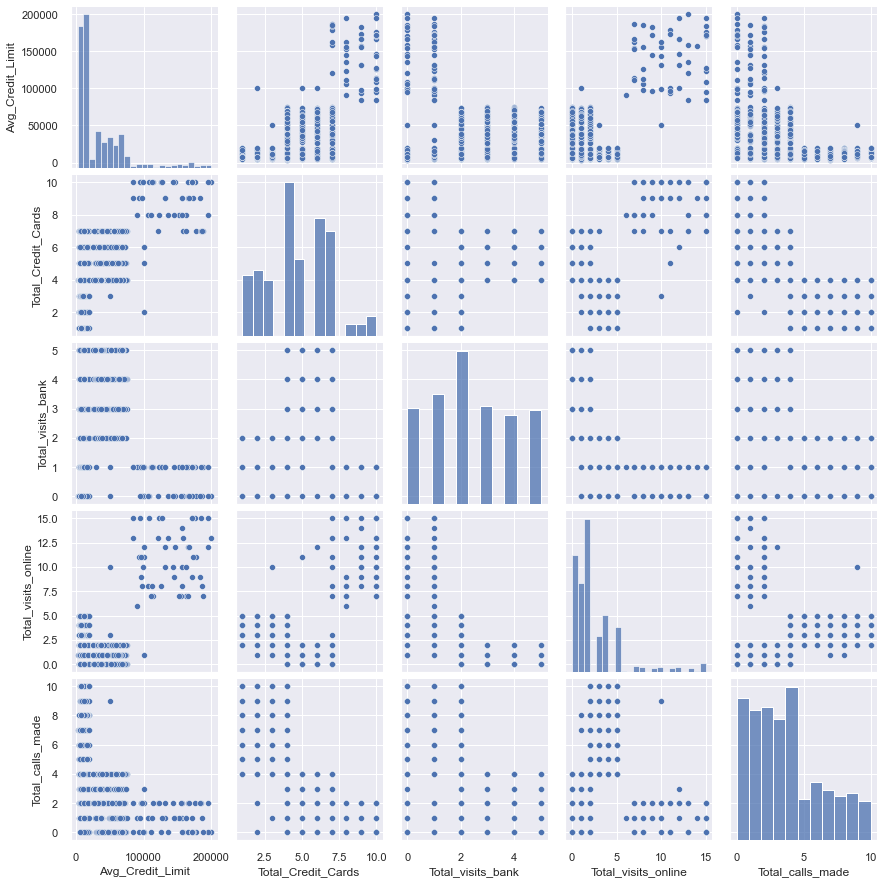

In [96]:
sns.pairplot(data=df)

<ul>
    <li>based on initial observation of data distribution 2 or 3 clusters might suffice</li>
    <li>the dataset heavily skews in favor of high avg_credit_limit</li>
    <li>no clear linear relationship forms in the distributions</li>
</ul>

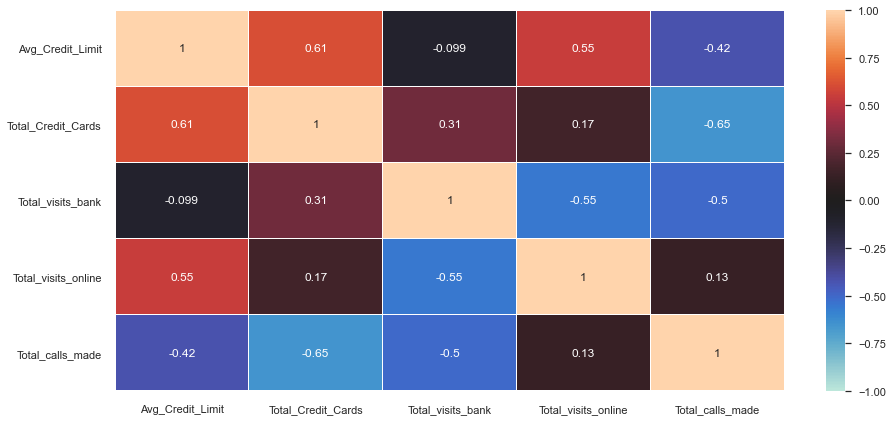

In [97]:
plt.figure(figsize=(15,7))

sns.heatmap(df[all_col].corr(),
            annot=True,
            linewidths=0.5,vmin=-1,vmax=1,
            center=0,
            cbar=True,)            

plt.show()



<ul>
<li>There is a high correlation between Avg_Credit_Limit and Total_Credit_Cards.</li>
<li>There is strong negative relationship betweem Calls_Made & the other contact methods</li>
</ul>


### Scaling the data

In [98]:
# Scaling the data set before clustering
all_col = df.columns.tolist()

scaler=StandardScaler()
subset=df[all_col].copy()
subset_scaled=scaler.fit_transform(subset)   

In [99]:
#Creating a dataframe from the scaled data above
subset_scaled_df=pd.DataFrame(subset_scaled,columns=subset.columns)



#### Applying K-means clustering algorithms

Number of Clusters: 1 	Average Distortion: 2.007896349270688
Number of Clusters: 2 	Average Distortion: 1.4576197022077821
Number of Clusters: 3 	Average Distortion: 1.1434401208195095
Number of Clusters: 4 	Average Distortion: 1.0435538595477063
Number of Clusters: 5 	Average Distortion: 0.988052836262114
Number of Clusters: 6 	Average Distortion: 0.9404952836425913
Number of Clusters: 7 	Average Distortion: 0.9072721051182121
Number of Clusters: 8 	Average Distortion: 0.887980231812261
Number of Clusters: 9 	Average Distortion: 0.8645947595040125


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

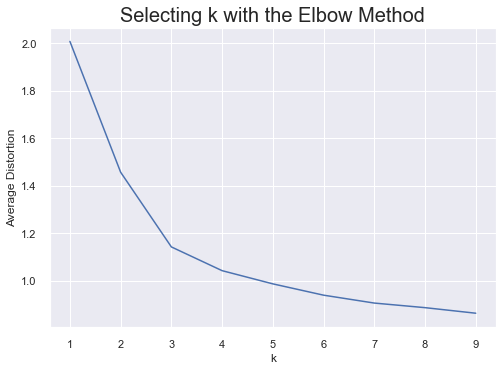

In [100]:
clusters=range(1,10)
meanDistortions=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(subset_scaled_df)
    prediction=model.predict(subset_scaled_df)
    distortion=sum(np.min(cdist(subset_scaled_df, model.cluster_centers_, 'euclidean'), axis=1)) / subset_scaled_df.shape[0]
                           
    meanDistortions.append(distortion)

    print('Number of Clusters:', k, '\tAverage Distortion:', distortion)

plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average Distortion')
plt.title('Selecting k with the Elbow Method', fontsize=20)



The appropriate value of k from elbow curve is 3


#### Lets us check the silhoutte score

In [101]:
sil_score = []
cluster_list = list(range(2,10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((subset_scaled_df))
    #centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.41800025566689647)
For n_clusters = 3, silhouette score is 0.516281010855363)
For n_clusters = 4, silhouette score is 0.3570238219413198)
For n_clusters = 5, silhouette score is 0.2730908848204728)
For n_clusters = 6, silhouette score is 0.2483437591902028)
For n_clusters = 7, silhouette score is 0.24801755822247074)
For n_clusters = 8, silhouette score is 0.2250377560111214)
For n_clusters = 9, silhouette score is 0.22484731426885302)


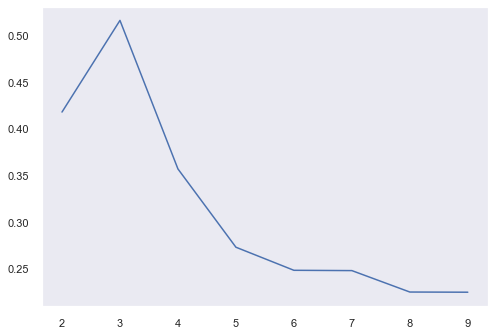

In [102]:
plt.plot(cluster_list,sil_score)
plt.grid()



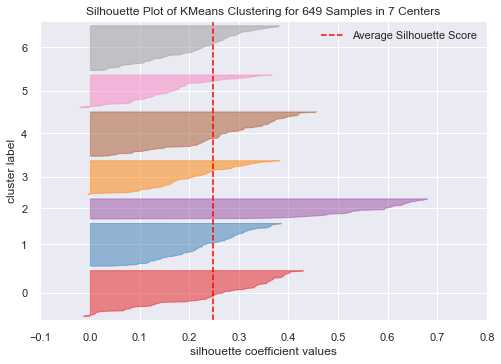

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 649 Samples in 7 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [103]:
#Finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(7, random_state = 1))
visualizer.fit(subset_scaled_df)    
visualizer.show()



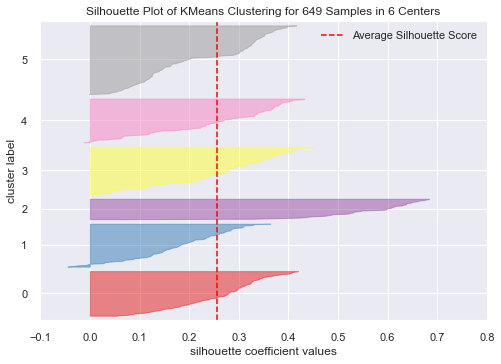

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 649 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [104]:
#Finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(6, random_state = 1))
visualizer.fit(subset_scaled_df)    
visualizer.show()



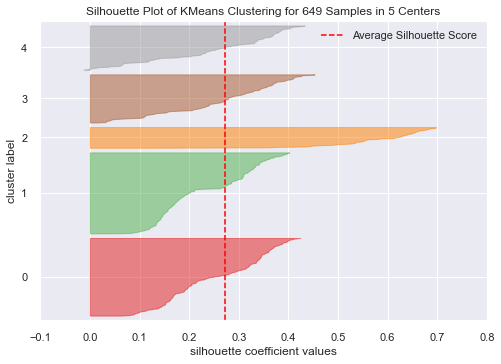

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 649 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [105]:
#Finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(5, random_state = 1))
visualizer.fit(subset_scaled_df)    
visualizer.show()



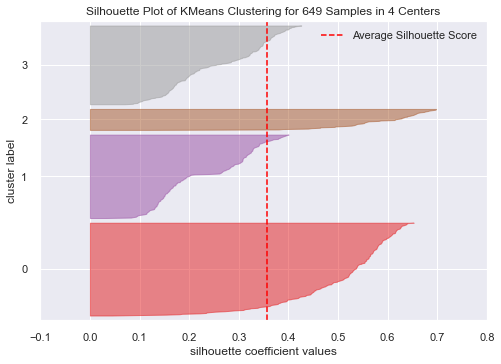

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 649 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [106]:
#Finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state = 1))
visualizer.fit(subset_scaled_df)    
visualizer.show()



#### Let us take 3 as appropriate no. of clusters as silhoutte score is high enough

In [107]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(subset_scaled_df)



KMeans(n_clusters=3, random_state=0)

In [108]:
df['K_means_segments'] = kmeans.labels_



In [109]:
cluster_profile = df.groupby('K_means_segments').mean()



In [139]:
cluster_profile['count_in_each_segment'] = df.groupby('K_means_segments')['Avg_Credit_Limit'].count().values

In [140]:
cluster_profile



,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
K_means_segments,,,,,,
0,141040.000000,8.740000,0.600000,10.900000,1.080000,50
1,34071.428571,5.518519,3.484127,0.981481,1.992063,378
2,12239.819005,2.411765,0.945701,3.561086,6.891403,221


<AxesSubplot:xlabel='K_means_segments'>

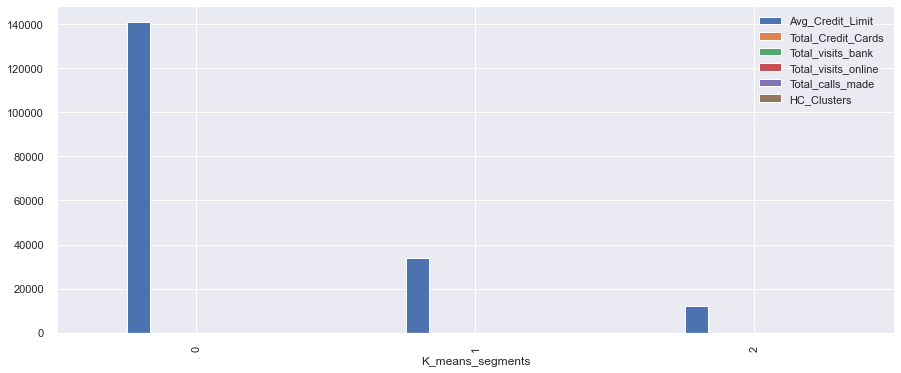

In [138]:
df.groupby('K_means_segments').mean().plot.bar(figsize=(15,6))



<AxesSubplot:xlabel='K_means_segments'>

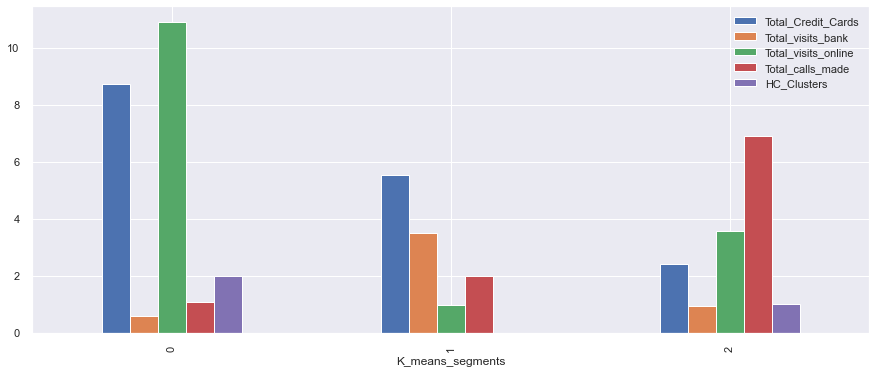

In [141]:
#dropping Avg_Credit_Limit to view other variables clearly
df2 = df.drop('Avg_Credit_Limit',axis=1)
df2.groupby('K_means_segments').mean().plot.bar(figsize=(15,6))


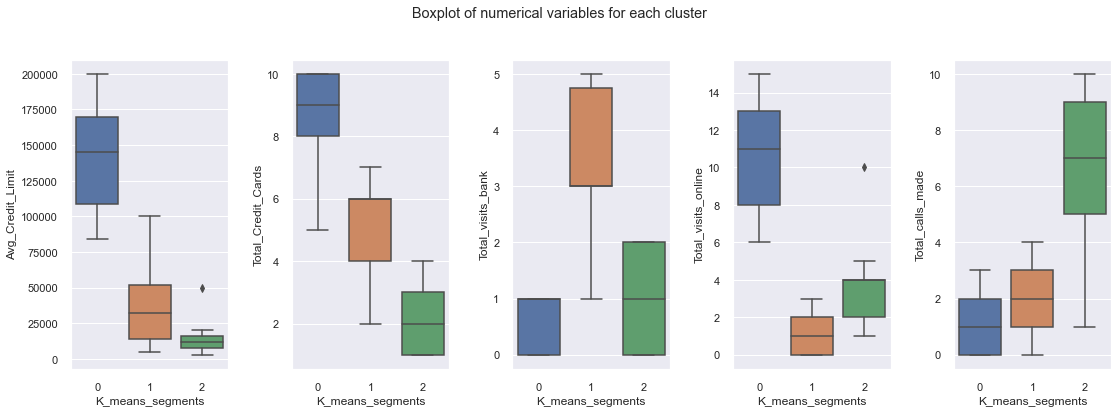

In [113]:
fig, axes = plt.subplots(1, 5,  figsize=(16, 6))
fig.suptitle('Boxplot of numerical variables for each cluster')
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii],y=df[all_col[counter]],x=df['K_means_segments'])
    counter = counter+1

fig.tight_layout(pad=2.0)



### Insights

- **Cluster 0**:
    - This cluster contains customers with a high Avg_Credit_Limit.
    - These customers have a minimum of 5 credit cards, with a max of 10.
    - The customers prefer visiting the bank online instead of in person.
    - Additionally, these customers do not contact the bank very often, with a maximum of 2 calls being made.
   
- **Cluster 1**:
    - Customers in Cluster 1 have a low-middling/high Avg_Credit_Limit. The majority of the customers fall between a Avg_Credit_Limit of 20k-50k~
    - The customers in this cluster have an average of 5 credit cards. 
    - These customers visit the bank in person far more than online. This is a big differing feature compared to the other clusters.
    - Similar to the first cluster, these customers do not make calls to the bank in a large volume
    
- **Cluster 2**:
    - The final cluster of customers have incredibly low Avg_Credit_Limit compared to the other customers.
    - These customers have very few credit cards, visit the bank in person and online infrequently
    - These customers call the bank far more than any other customer cluster.

### Using PCA Reduced Features & K-Means

In [114]:
from sklearn.decomposition import PCA
reduced_data = PCA(n_components=2).fit_transform(subset_scaled_df)
kmeans = KMeans(init="k-means++", n_clusters=3, n_init=4)
kmeans.fit(reduced_data)

KMeans(n_clusters=3, n_init=4)

In [115]:
df['K_means_segments'] = kmeans.labels_

In [116]:
cluster_profile = df.groupby('K_means_segments').mean()

In [117]:
cluster_profile['count_in_each_segment'] = df.groupby('K_means_segments')['Total_Credit_Cards'].count().values

In [118]:
cluster_profile


,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
K_means_segments,,,,,,
0,141040.000000,8.740000,0.600000,10.900000,1.080000,50
1,34071.428571,5.518519,3.484127,0.981481,1.992063,378
2,12239.819005,2.411765,0.945701,3.561086,6.891403,221


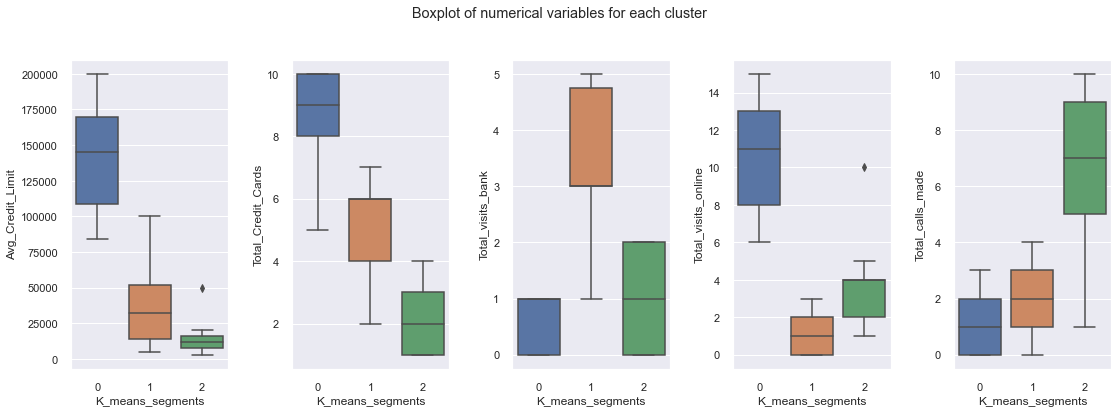

In [119]:
fig, axes = plt.subplots(1, 5,  figsize=(16, 6))
fig.suptitle('Boxplot of numerical variables for each cluster')
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii],y=df[all_col[counter]],x=df['K_means_segments'])
    counter = counter+1

fig.tight_layout(pad=2.0)



### Insights

- **Cluster 0**:
    - This cluster contains customers with a low Avg_Credit_Limit.
    - These customers have a minimum of 2 credit cards, with a max of 7.
    - The customers prefer visiting the bank in person far more than online
    - The customers in this cluster call the bank, but not very much.
   
- **Cluster 1**:
    - Cluster 1 customers have the lowest range of Avg_Credit_Limit
    - These customers do not have many Credit Cards, nor do they visit the bank in person very often
    - When these customers do choose to contact the bank, they do so via calls in a large volume.
    
- **Cluster 2**:
    - The customers who have incredibly high Avg_Credit_Limit, number of Credit Cards and Online visits fall into this cluster.
    - These customers do not visit the bank in person very often, and they do not call the bank very often either.

### Applying Hierarchical clustering

In [120]:
# cophenet index is a measure of the correlation between the distance of points in feature space and distance on dendrogram
# closer it is to 1, the better is the clustering
distance_metrics = [ 'euclidean','chebyshev','mahalanobis','cityblock']
linkage_methods = ['single', 'complete', 'average', 'weighted']
high_cophenet_corr = 0
high_dm_lm = [0,0]
for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z , pdist(subset_scaled_df))
        print('Cophent correlation for distance metrics {} and linkage method {} is {}'.format(dm,lm,c))
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm
            
            



Cophent correlation for distance metrics euclidean and linkage method single is 0.7395135051413775
Cophent correlation for distance metrics euclidean and linkage method complete is 0.8794736468795109
Cophent correlation for distance metrics euclidean and linkage method average is 0.8974425535306298
Cophent correlation for distance metrics euclidean and linkage method weighted is 0.8551098644586315
Cophent correlation for distance metrics chebyshev and linkage method single is 0.7379112982920528
Cophent correlation for distance metrics chebyshev and linkage method complete is 0.8578617029322211
Cophent correlation for distance metrics chebyshev and linkage method average is 0.8960370054789858
Cophent correlation for distance metrics chebyshev and linkage method weighted is 0.893309534644998
Cophent correlation for distance metrics mahalanobis and linkage method single is 0.7054746377393306
Cophent correlation for distance metrics mahalanobis and linkage method complete is 0.651336904797

In [121]:
print('Highest cophenet correlation is {}, which is obtinaed with {} distance metric and {} linkage method'.format(high_cophenet_corr ,high_dm_lm[0],high_dm_lm[1]))

Highest cophenet correlation is 0.8974425535306298, which is obtinaed with euclidean distance metric and average linkage method


#### Exploring 'centroid', 'median','ward' linkage method which requires only Euclidean distance metrics

In [122]:
linkage_methods = ['single', 'complete', 'average','median','ward', 'weighted']
high_cophenet_corr = 0
high_dm_lm = [0,0]

for lm in linkage_methods:
    Z = linkage(subset_scaled_df, metric='euclidean', method=lm)
    c, coph_dists = cophenet(Z , pdist(subset_scaled_df))
    print('Cophent correlation for distance metrics {} and linkahe method {} is {}'.format('euclidean',lm,c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = dm
        high_dm_lm[1] = lm
print('*'*110)
print('Highest cophenet correlation is {}, which is obtinaed with {} distance metric and {} linkage method'.format(high_cophenet_corr ,high_dm_lm[0],high_dm_lm[1]))

Cophent correlation for distance metrics euclidean and linkahe method single is 0.7395135051413775
Cophent correlation for distance metrics euclidean and linkahe method complete is 0.8794736468795109
Cophent correlation for distance metrics euclidean and linkahe method average is 0.8974425535306298
Cophent correlation for distance metrics euclidean and linkahe method median is 0.8806884020604272
Cophent correlation for distance metrics euclidean and linkahe method ward is 0.7425813590948763
Cophent correlation for distance metrics euclidean and linkahe method weighted is 0.8551098644586315
**************************************************************************************************************
Highest cophenet correlation is 0.8974425535306298, which is obtinaed with cityblock distance metric and average linkage method


#### Obserations:

<ul>
    <li>highest cophenet correlation belongs to cityblock distance metric with average linkage</li>
    <li>we will plot the dendograms for the different linkage methods</li>
</ul>

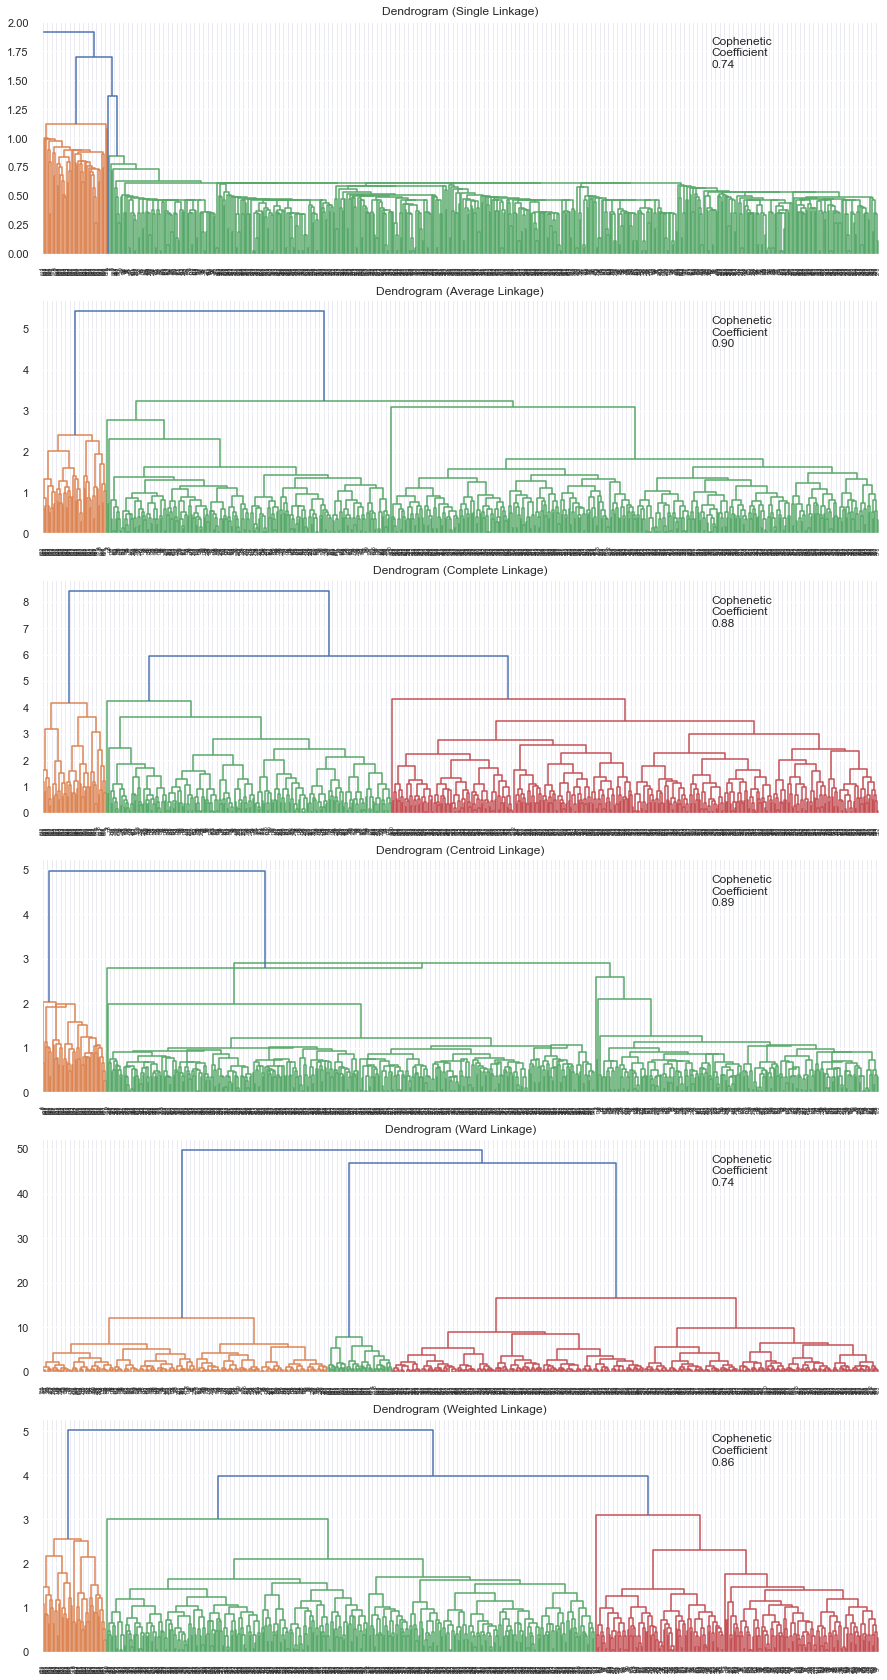

In [123]:
# List of all linkage methods to check
methods = ['single',
           'average', 
           'complete',
           'centroid',
           'ward',
          'weighted']

# Calculate the pairwise distance form the dataset to be used in the cophenetic correlation calculation
#pw_distance = pdist(credit_scaled)

# Create lists to save results of coph calculation
compare_cols = ['Linkage', 'Cophenetic Coefficient']
compare = []

# Create a subplot image
fig, axs = plt.subplots(len(methods), 1, figsize=(15, 30))

# Enumerate through the list of all methods above
# Get linkage, plot dendrogram, calculate cophenetic coefficient
for i, method in enumerate(methods):
    
    Z = linkage(subset_scaled_df, metric='euclidean', method=method)

    dendrogram(Z, ax=axs[i]);
    axs[i].set_title(f'Dendrogram ({method.capitalize()} Linkage)')
    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
    axs[i].annotate(f'Cophenetic\nCoefficient\n{coph_corr:0.2f}', 
                    (0.80, 0.80),
                    xycoords='axes fraction')
    compare.append([method, coph_corr])

#### Observations:

The dendograms all reveal 3 well defined clusters

In [124]:
# Create and print dataframe to compare Cophenetic Coefficient for each linkage
df_cc = pd.DataFrame(compare, columns=compare_cols)
df_cc



,Linkage,Cophenetic Coefficient
0,single,0.739514
1,average,0.897443
2,complete,0.879474
3,centroid,0.894471
4,ward,0.742581
5,weighted,0.855110


#### Observations:

Let us see the dndrogram of 'mahalanobis', 'euclidian','cityblock' with 'average', 'weighted' linkage method as they gave high cophenetic correlation value

In [125]:
distance_metrics = [ 'mahalanobis','cityblock']
linkage_methods = ['average', 'weighted']

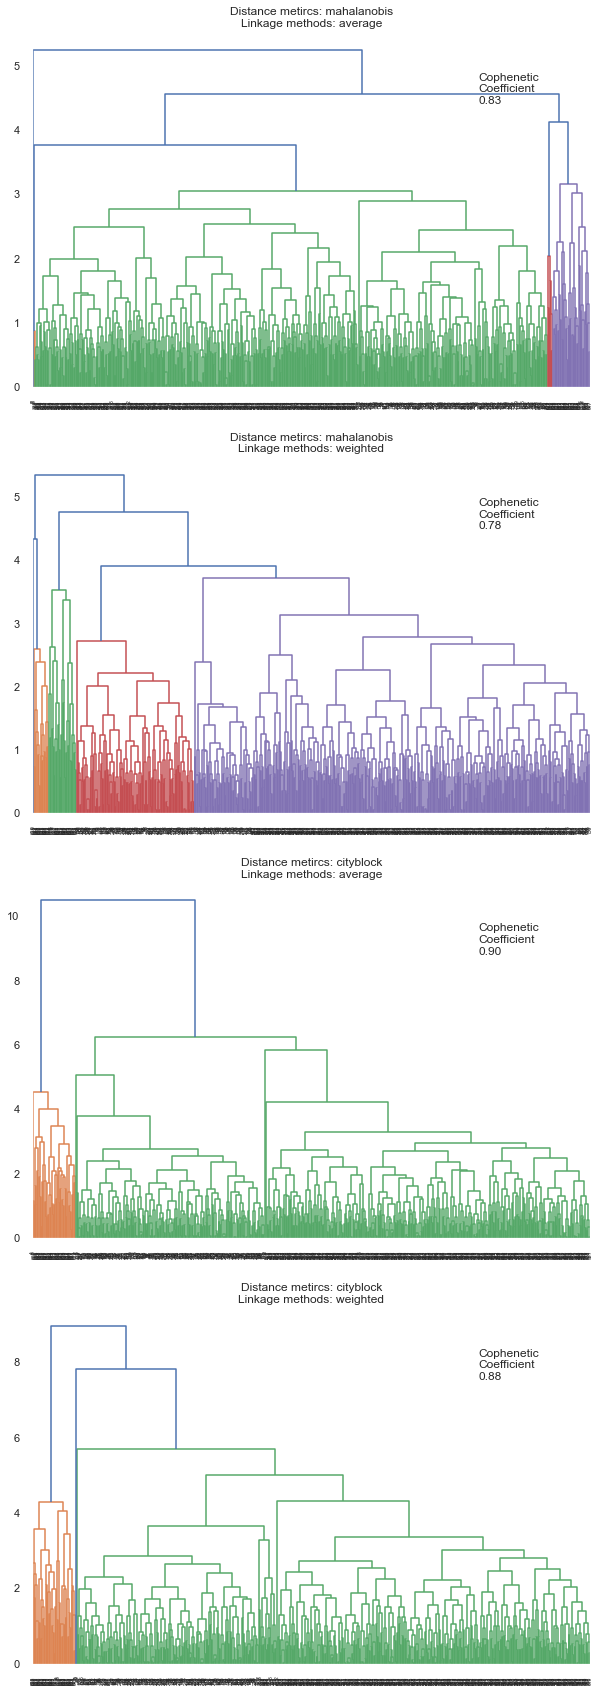

In [126]:
# Create a subplot image
fig, axs = plt.subplots(len(distance_metrics)+len(distance_metrics), 1, figsize=(10, 30))
i=0
for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, metric=dm, method=lm)
        dendrogram(Z,  ax=axs[i]);
        axs[i].set_title('Distance metircs: {}\nLinkage methods: {}'.format(dm,lm))
        coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
        axs[i].annotate(f'Cophenetic\nCoefficient\n{coph_corr:0.2f}', 
                        (0.80, 0.80),
                        xycoords='axes fraction')
        axs[i].set_title('Distance metircs: {}\nLinkage methods: {}'.format(dm,lm))                        
        i +=1
       



In [127]:
distance_metrics = [ 'Euclidean']
linkage_methods = ['average']

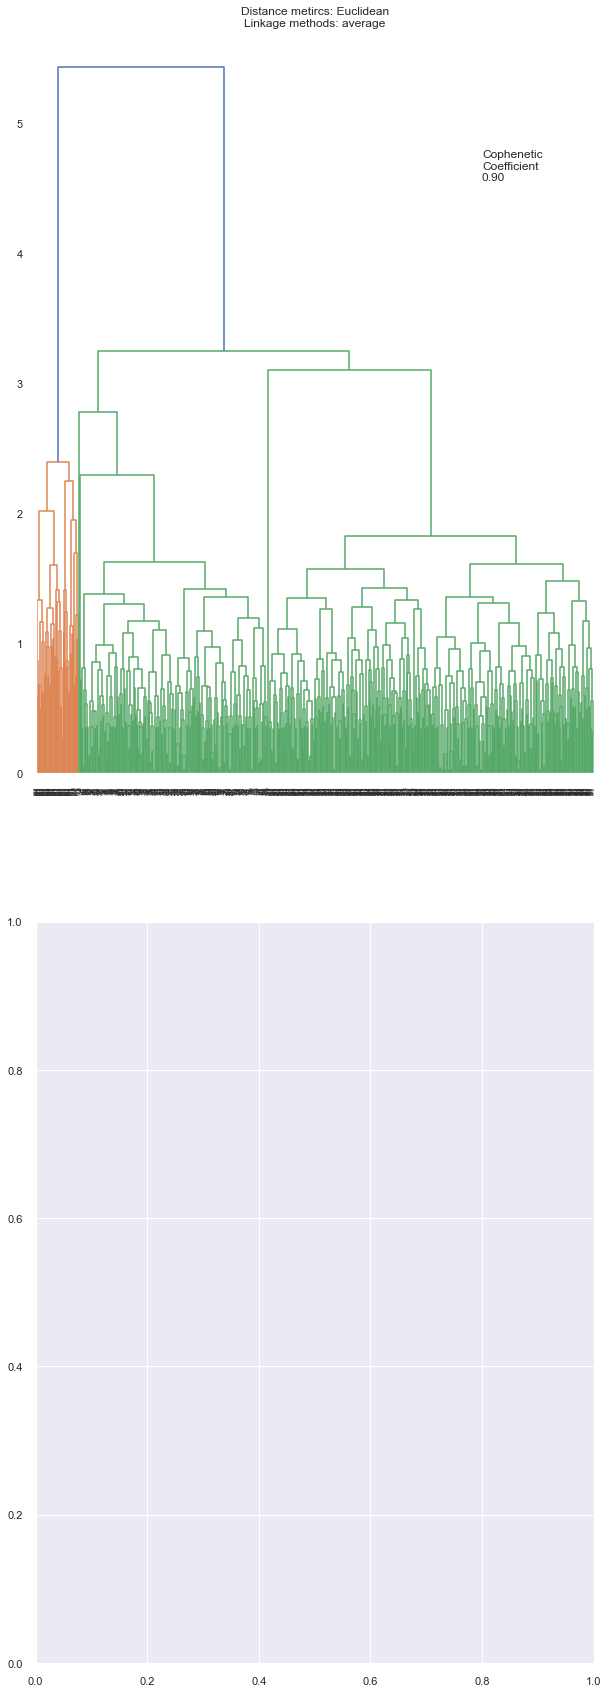

In [128]:
# Create a subplot image
fig, axs = plt.subplots(len(distance_metrics)+len(distance_metrics), 1, figsize=(10, 30))
i=0
for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, method=lm)
        dendrogram(Z,  ax=axs[i]);
        axs[i].set_title('Distance metircs: {}\nLinkage methods: {}'.format(dm,lm))
        coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
        axs[i].annotate(f'Cophenetic\nCoefficient\n{coph_corr:0.2f}', 
                        (0.80, 0.80),
                        xycoords='axes fraction')
        axs[i].set_title('Distance metircs: {}\nLinkage methods: {}'.format(dm,lm))                        
       
       


**Observations**
- Out of all the dendrogram we saw, it is clear that dendrogram with ward linkage method gave us separate and distinct clusters
- 3 cluster would be appropriate number of cluster from dendrogram with ward linkage method  

In [129]:
#Trying with K value as 3
HCmodel = AgglomerativeClustering(n_clusters=3,affinity='euclidean', linkage='ward')
HCmodel.fit(subset_scaled_df)
subset_scaled_df['HC_Clusters'] = HCmodel.labels_

In [130]:
df['HC_Clusters'] = HCmodel.labels_

In [131]:
hccluster_profile = df.groupby('HC_Clusters').mean()



In [132]:
hccluster_profile['count_in_each_segments'] = df.groupby('HC_Clusters')['Total_Credit_Cards'].count().values

In [133]:
# lets display cluster profile
hccluster_profile.style.highlight_max(color = 'lightgreen', axis = 0)



,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments,count_in_each_segments
HC_Clusters,,,,,,,
0,34143.236074,5.519894,3.488064,0.978780,1.986737,1.000000,377
1,12216.216216,2.423423,0.950450,3.554054,6.878378,1.995495,222
2,141040.000000,8.740000,0.600000,10.900000,1.080000,0.000000,50


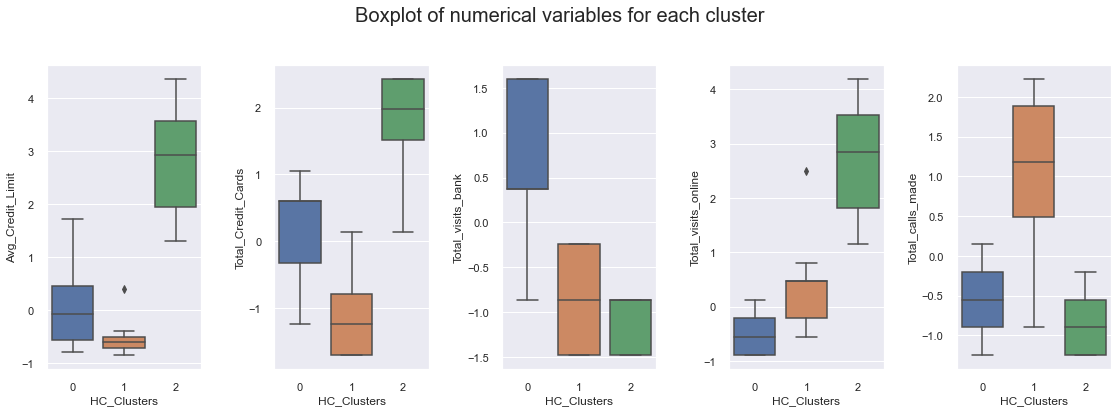

In [134]:
fig, axes = plt.subplots(1, 5,  figsize=(16, 6))
fig.suptitle('Boxplot of numerical variables for each cluster', fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii],y=subset_scaled_df[all_col[counter]],x=subset_scaled_df['HC_Clusters'])
    counter = counter+1

fig.tight_layout(pad=2.0)



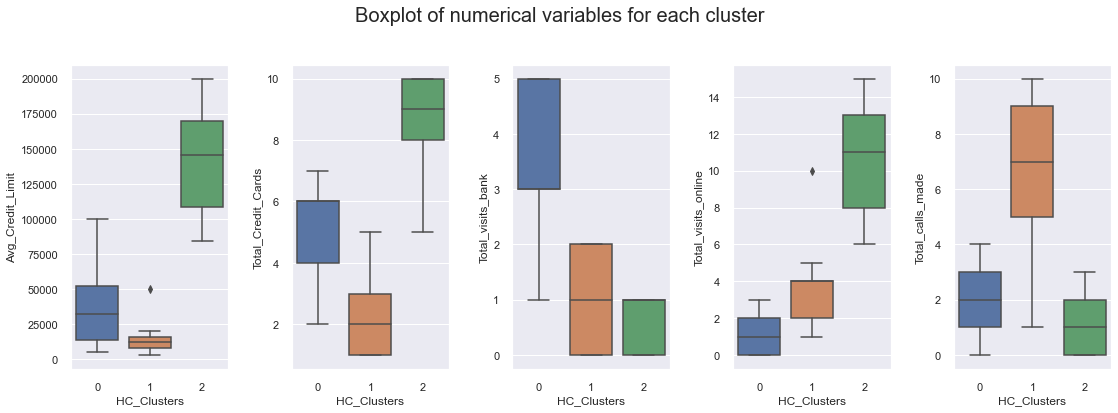

In [135]:
fig, axes = plt.subplots(1, 5,  figsize=(16, 6))
fig.suptitle('Boxplot of numerical variables for each cluster', fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii],y=df[all_col[counter]],x=df['HC_Clusters'])
    counter = counter+1

fig.tight_layout(pad=2.0)



### Insights

- **Cluster 0**:
    - This cluster contains customers with a middling average Avg_Credit_Limit.
    - These customers have a minimum of 2 credit cards, with a max of 7.
    - The customers prefer visiting the bank online instead of in person by a large margin
    - Additionally, these customers do not contact the bank very often, with a maximum of 4 calls being made.
   
- **Cluster 1**:
    - Customers in Cluster 1 have a very low Avg_Credit_Limit. 
    - The customers in this cluster have an average of 1-3 credit cards. 
    - These customers visit the bank in person and online at almost the same rate.
    - Unlike the other clusters, these customers have very high Total Calls Made.
    
- **Cluster 2**:
    - The final cluster of customers have incredibly high Avg_Credit_Limit compared to the other customers.
    - These customers have a large number of credit cards
    - The customers tend not to visit the bank in person, or call the bank. They interact with the bank through the online portal far more frequently.

### Obsercations about Clusters:

3 Clusters were clearly defined by the various clustering techniques.

<b>They differ in the following way:</b>

The major differing factors that were identified in the various clustering models is a customers Avg_Credit_Limit and their preferences for contact methods.

We can see that customers who have a lot of credit cards, tend to also have very high Avg_Credit_Limit and tend to contact the bank via online.

The remaining customers are then divided based on their Avg_Credit_Limit and contact preference. We see that the "middling" customer typically has a low-medium Avg_Credit_Limit with no major difference in whether they visit online, or in person.

### Business Recommendation:

Customers who have a high Avg_Credit_Limit should be contacted via online. Whether this is email campaigns or a online support tool, to improve customer service satisfaction and improve their relationship with the bank it is clear the bank should focus on their online features.

Customers who have low-average Avg_Credit_Limits can be identified as the largest potential pool for increasing revenue by moving these customers into the above mentioned "High Avg_Credit_Limit" cluster. To achieve this, the bank should focus on upselling additional credit cards or services, as we have seen that the more Credit Cards a customer has, the higher the Avg_Credit_Limit is. These customers can be targeted with Call-based-marketing campaigns. They have a preference for calling, and we can easily commit more resources to maximizing this contact avenue.

The last customer cluster includes customers who do not have many credit cards, nor do they have a high Avg_Credit_Limit. Products that are on the cheaper side, and appeal to lower income customers should be the focus of new business/marketing efforts. In-place of focusing on improving service, the bank should focus on "New Customer" specials or products.